In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform

from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

Helper functions

In [3]:
def min_max_scale(x):
    """Does same thing as sklearn.preprocessing.MinMaxScaler().fit_transform(x)"""
    return (x - x.min()) / (x.max() - x.min())


def calc_dist_df(X, metric="euclidean"):
    """Calc square distance matrix with pdist and convert to a dataframe"""
    dist_mat = squareform(pdist(X, metric=metric))
    dist_df = pd.DataFrame(dist_mat, index=X.index, columns=X.index)

    return dist_df


def plot_dist_compare(X_hi_d, X_lo_d):
    """Given 2 input data samples, plot heatmaps of their distance matrices side by side"""
    dist_df_hi_d = calc_dist_df(X_hi_d)
    dist_df_lo_d = calc_dist_df(X_lo_d)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.heatmap(dist_df_hi_d, ax=axes[0], cbar=False)
    axes[0].set_title("High-d")

    sns.heatmap(dist_df_lo_d, ax=axes[1], cbar=False)
    axes[1].set_title("Low-d")

    plt.suptitle("Comparing Distances in High Dim vs Low Dim\n(darker means closer)")

    plt.tight_layout()

<IPython.core.display.Javascript object>

In [4]:
def plot_scatter_compare():
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.scatterplot(
        "x1", "x2", hue="color", data=df_small, hue_order=hue_order, ax=axes[0]
    )
    axes[0].legend().remove()
    axes[0].set_title("Input Data")

    sns.scatterplot(
        "one_d", "zero", hue="color", data=df_small, hue_order=hue_order, ax=axes[1]
    )
    axes[1].legend().remove()
    axes[1].set_title("Reduced Data")
    axes[1].set_yticks([])
    axes[1].set_ylabel("")

<IPython.core.display.Javascript object>

Make up some data to play with.

In [6]:
X, y = make_blobs(n_samples=300, n_features=2, centers=4, random_state=42)

# Full data
df = pd.DataFrame(X, columns=["x1", "x2"])
df["label"] = y

color_map = {0: "blue", 1: "orange", 2: "green", 3: "red"}
hue_order = list(color_map.values())
df["color"] = df["label"].replace({0: "blue", 1: "orange", 2: "green", 3: "red"})
df["zero"] = 0

# Sample for demo
df_small = df.sample(8, random_state=1337)
df_small = df_small.sort_values("color")
df_small = df_small.reset_index(drop=True)
df_small.index = df_small["color"] + "_" + df_small.index.astype(str)

<IPython.core.display.Javascript object>

Full dataset that we'll get to:

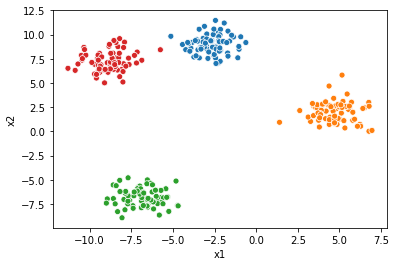

<IPython.core.display.Javascript object>

In [7]:
sns.scatterplot("x1", "x2", hue="color", data=df, hue_order=hue_order)
plt.legend().remove()
plt.show()

More manageable data size to visualize pairwise distances:

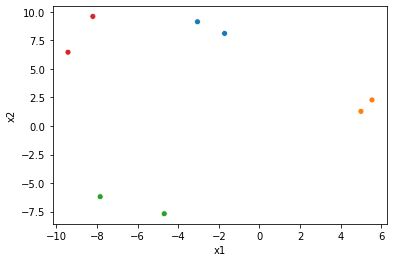

<IPython.core.display.Javascript object>

In [8]:
sns.scatterplot("x1", "x2", hue="color", data=df_small, hue_order=hue_order)
plt.legend().remove()
plt.show()

## t-SNE and UMAP High Level Steps

#### Very very high level:

1. Make a bad guess of how to place points.
2. Compare low-d distances to high-d distances.
3. Update guess of how to place points until high & low dim distances are similar.

---

#### A little more detail:

1. Measure the distance/similarity between points in high dimension.
2. Make a (bad) guess at the locations of the points in low-d.
3. Measure the distance/similarity between points in low-d.
4. Compare the distances between high and low dimensions (calculated in 1 and 3).  Use a measure of how good we did (this is called the *loss*).
5. Nudge low-d points to make the distances more similar between high and low dimensions.
6. Repeat steps 3-5 until it's as good as it's gonna be.

### 1. Measure the distance/similarity between points in high dimension

Calculate the distance between each observation and display the info:
* using `.style.background_gradient` with `axis=None`
* using `sns.heatmap`

In [12]:
X = df_small[["x1", "x2"]]
dist_mat = squareform(pdist(X, metric="euclidean"))
dist_df_2d = pd.DataFrame(dist_mat, columns=X.index, index=X.index)

<IPython.core.display.Javascript object>

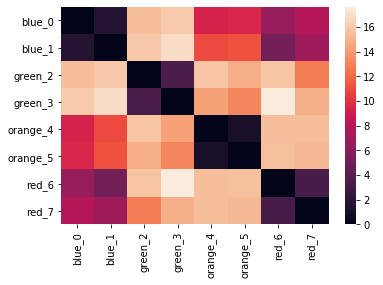

<IPython.core.display.Javascript object>

In [13]:
sns.heatmap(dist_df_2d)

### 2. Make a (bad) guess at the locations of the points in low-d

Here, we'll just randomly place the points in 1d space.

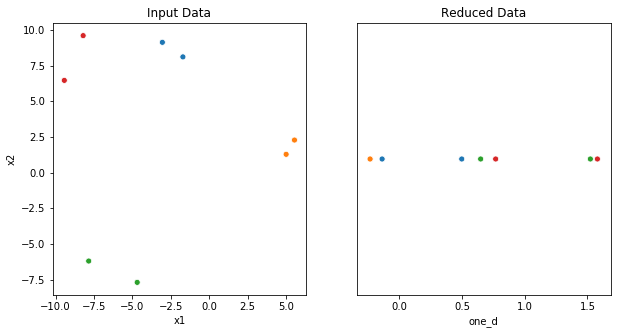

<IPython.core.display.Javascript object>

In [14]:
np.random.seed(42)

df_small["one_d"] = np.random.normal(size=df_small.shape[0])

plot_scatter_compare()
plt.show()

### 3. Measure the distance/similarity between points in low-d.

Repeating distance calc from before.

In [15]:
dist_mat = squareform(pdist(df_small[["one_d"]]))

dist_df_1d = pd.DataFrame(dist_mat, index=df_small.index, columns=df_small.index)
dist_df_1d.style.background_gradient(axis=None)

,blue_0,blue_1,green_2,green_3,orange_4,orange_5,red_6,red_7
blue_0,0.000000,0.634978,0.150974,1.026316,0.730868,0.730851,1.082499,0.270721
blue_1,0.634978,0.000000,0.785953,1.661294,0.095889,0.095873,1.717477,0.905699
green_2,0.150974,0.785953,0.000000,0.875341,0.881842,0.881825,0.931524,0.119746
green_3,1.026316,1.661294,0.875341,0.000000,1.757183,1.757167,0.056183,0.755595
orange_4,0.730868,0.095889,0.881842,1.757183,0.000000,0.000016,1.813366,1.001588
orange_5,0.730851,0.095873,0.881825,1.757167,0.000016,0.000000,1.813350,1.001572
red_6,1.082499,1.717477,0.931524,0.056183,1.813366,1.813350,0.000000,0.811778
red_7,0.270721,0.905699,0.119746,0.755595,1.001588,1.001572,0.811778,0.000000


<IPython.core.display.Javascript object>

### 4. Compare the distances between high and low dimensions. Use a measure of how good we did (this is called the loss).

We won't use an actual loss measure for this demo.  We'll use heatmaps and judge how well they match.  If we do perfectly, the heatmaps will be identical.

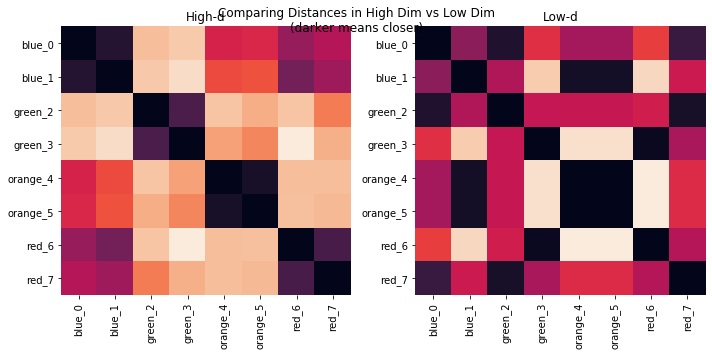

<IPython.core.display.Javascript object>

In [16]:
plot_dist_compare(df_small[["x1", "x2"]], df_small[["one_d"]])
plt.show()

If you wanted to make up a loss, maybe you normalize the distance matrices and calculate the difference between the 2.

In [17]:
def made_up_loss(X1, X2):
    # Calc square dist matrix for each data set
    dist_df_1 = calc_dist_df(X1)
    dist_df_2 = calc_dist_df(X2)

    # Scale to have max distance be 1 and min distance be 0
    dist_df_1 = min_max_scale(dist_df_1)
    dist_df_2 = min_max_scale(dist_df_2)

    # Find the difference between the 2
    diffs = dist_df_1 - dist_df_2

    # Taking absolute value of differences and summing
    # aka: calculating L1 distance
    return diffs.abs().sum().sum()

<IPython.core.display.Javascript object>

In [18]:
made_up_loss(df_small[["x1", "x2"]], df_small[["one_d"]])

18.88860094454522

<IPython.core.display.Javascript object>

### 5. Nudge low-d points to make the distances more similar between high and low dimensions.

For this demo, we're not going to intelligently nudge the points in the right direction.  Instead, we'll randomly generate locations again with a preset seed that I know works better.

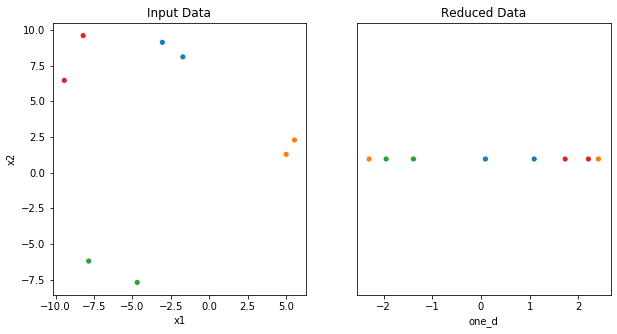

<IPython.core.display.Javascript object>

In [19]:
np.random.seed(8)

df_small["one_d"] = np.random.normal(size=df_small.shape[0])

plot_scatter_compare()
plt.show()

### Repeat 3 & 4:
  * 3. Measure dist in low-d.
  * 4. Compare to hi-d

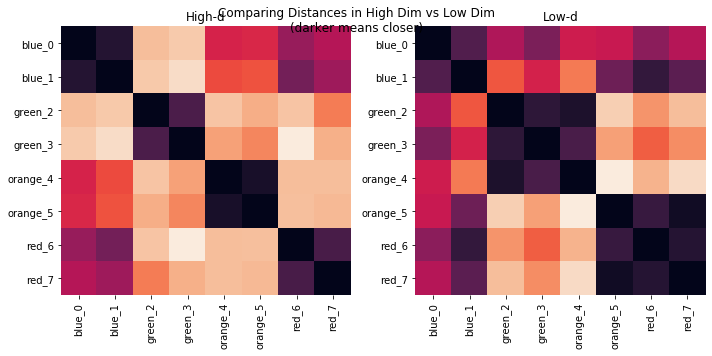

<IPython.core.display.Javascript object>

In [20]:
plot_dist_compare(df_small[["x1", "x2"]], df_small[["one_d"]])

In [21]:
made_up_loss(df_small[["x1", "x2"]], df_small[["one_d"]])

16.798516466163438

<IPython.core.display.Javascript object>

### Repeat 5:
  * Nudge points
  
Reminder that we are not actually doing t-SNE or UMAP here.  They both would intelligently nudge the points.  I just kept re-running this random placement untils the results were good enough.

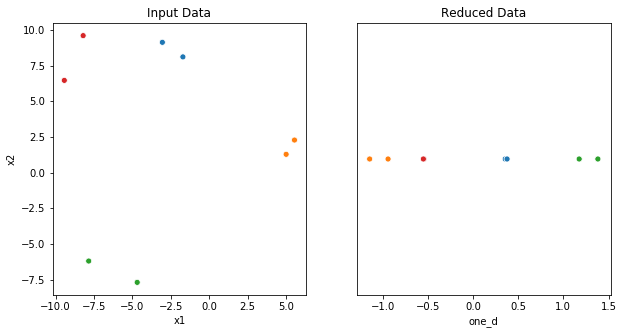

<IPython.core.display.Javascript object>

In [22]:
np.random.seed(444)

df_small["one_d"] = np.random.normal(size=df_small.shape[0])

plot_scatter_compare()
plt.show()

### Repeat:
  * 3. Measure dist in low-d.
  * 4. Compare to hi-d

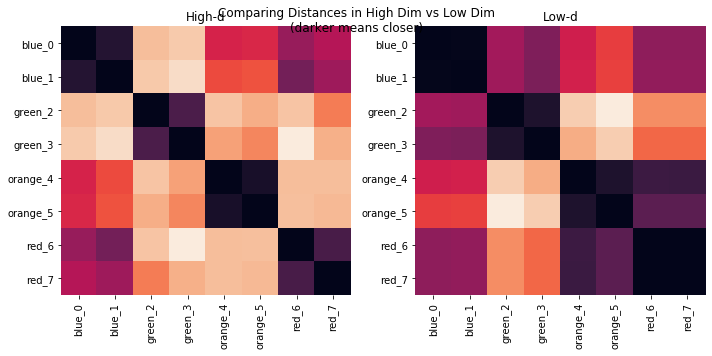

<IPython.core.display.Javascript object>

In [23]:
plot_dist_compare(df_small[["x1", "x2"]], df_small[["one_d"]])

In [24]:
made_up_loss(df_small[["x1", "x2"]], df_small[["one_d"]])

14.921874531882002

<IPython.core.display.Javascript object>

### Global vs Local Structure

The main thing we'll be managing with both of these algorithms (t-SNE & UMAP) is how much they should care about global structure.  Should they just focus on preserving local neighborhoods or should they try and preserve everything?

In our example, preserving local neighborhoods means that all the colors stay togehter.

In our example, preserving global structure means the clusters should stay about the same distance apart and this might come at the cost of mixing up clusters that are close to each other.

---

Below shows an arrangement of our points that is a little more focused on global structure.  Notice that the red and blue now overlap, but in the original data data the red and blue data were close to each other.

Being more global means that you consider people further away from you to be your neighbors.

The closest cluster to red/blue in the original data is orange and green is the furthest from red/blue.  Both of these more global relationships are reflected in the reduction.

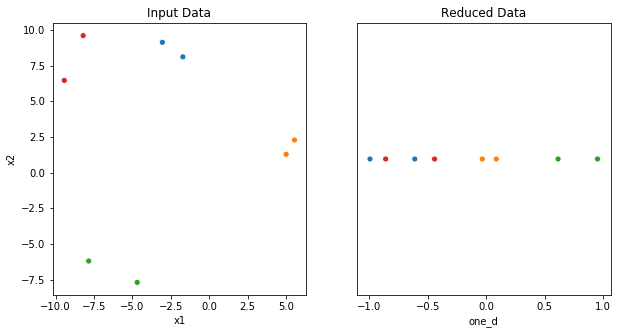

<IPython.core.display.Javascript object>

In [26]:
np.random.seed(2626)

df_small["one_d"] = np.random.normal(size=df_small.shape[0])

plot_scatter_compare()
plt.show()

## Actually applying TSNE

In [ ]:
df.head()

* Group 1: only use `perplexity` values in the range [1, 20]
* Group 2: only use `perplexity` values in the range [41, 60]

* Create a scatter plot of `df`.
    * Use `x1` as the x-axis, `x2` as the y-axis, & color by the `color` column.
* Apply `TSNE` to `df` (only use the `x1` and `x2` columns).
    * set `n_components` to 1 to get 1 d data out
    * set the `perplexity` to manage the trade-off between global vs. local
* Save the transformed 1-dimensional data from `TSNE` as a new column in `df`
* Recreate a scatter plot of `df`.
    * Use your newly added column as the x-axis, the `zero` column as the y-axis, & color by the `color` column.
    
    
* How do you think it did?
    * How well did it preserve local structure?
    * How well did it preserve global structure?

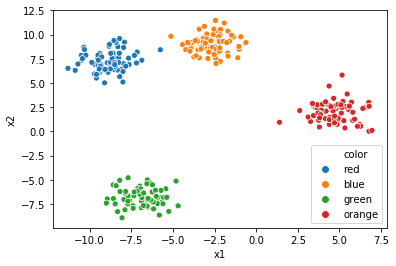

<IPython.core.display.Javascript object>

In [28]:
# Create a scatterplot of df
# Use x1 as the x-axis,
#     x2 as the y-axis, &
#     color by the color column.

sns.scatterplot("x1", "x2", data=df, hue="color")

In [53]:
# Apply TSNE to df (only use the x1 and x2 columns)
# Save the transformed 1-dimensional data from TSNE as a new column in df
tsne = TSNE(n_components=1, perplexity=41)
df_tsne = tsne.fit_transform(df[["x1", "x2"]])

<IPython.core.display.Javascript object>

In [54]:
df["tsne_1"] = df_tsne

<IPython.core.display.Javascript object>

In [55]:
df

,x1,x2,label,color,zero,tsne_1
0,-9.297689,6.473679,3,red,0,-3.173375
1,-9.698741,6.938967,3,red,0,-2.535768
2,-1.686653,7.793442,0,blue,0,16.485926
3,-7.097308,-5.781333,2,green,0,-20.170019
4,-10.876452,6.315437,3,red,0,-1.778213
...,...,...,...,...,...,...
295,-3.660191,9.389984,0,blue,0,13.923310
296,3.810884,1.412989,1,orange,0,2.837678
297,-4.116681,9.198920,0,blue,0,14.119929
298,-8.819909,8.999960,3,red,0,-6.391852


<IPython.core.display.Javascript object>

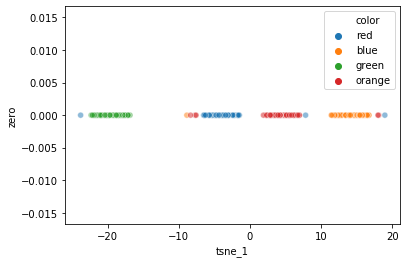

<IPython.core.display.Javascript object>

In [56]:
# Recreate a scatter plot of df
# Use your newly added column as the x-axis,
#     the zero column as the y-axis, &
#     color by the color column.
sns.scatterplot("tsne_1", "zero", data=df, hue="color", alpha=0.5)

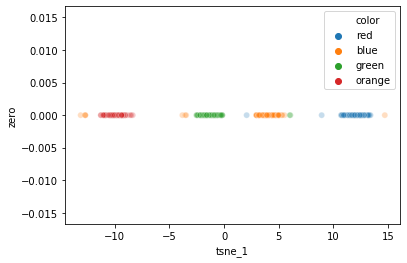

<IPython.core.display.Javascript object>

In [58]:
tsne = TSNE(n_components=1, perplexity=60)
df_tsne = tsne.fit_transform(df[["x1", "x2"]])
df["tsne_1"] = df_tsne
sns.scatterplot("tsne_1", "zero", data=df, hue="color", alpha=0.25)

In [50]:
df["color"].value_counts()

blue      75
orange    75
green     75
red       75
Name: color, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
# How do you think it did?
#    * How well did it preserve local structure?

#    * How well did it preserve global structure?